# Visualization & Diagnostics


What is a "good" embedding model for the biological sequences of our interest? And how do we visualize properties and embeddings using seqme? We will answer these two questions in this notebook.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seqme as sm

## Embedding models


Let's start by loading some sequences.


In [ ]:
DATASET_PATHS = {
    "UniProt": "./data/uniprot/uniprot_8_50_100.fasta",
    "AMP-data": "./data/amps.fasta",
}

In [ ]:
datasets = {name: sm.utils.read_fasta_file(path) for name, path in DATASET_PATHS.items()}

In [ ]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

UniProt: 2933310 sequences
AMP-data: 38473 sequences


In [ ]:
n_samples = 3000
seed = 42

data = {
    name: sm.utils.random_subset(sequences, n_samples=n_samples, seed=seed) if len(sequences) > n_samples else sequences
    for name, sequences in datasets.items()
}

### Diagnostics


We are interested in selecting an embedding model which orders the embedding space by "AMP"-likeness, i.e., the degree in which a peptides "looks" like a peptide with antimicrobial properties.


In [ ]:
models = {
    "Physico-chemical": sm.models.Concatenate(
        predictors=[
            sm.models.MinMaxNorm(sm.models.AliphaticIndex()),
            sm.models.MinMaxNorm(sm.models.Charge()),
        ]
    ),
    "esm2": sm.models.Esm2(
        model_name=sm.models.Esm2Checkpoint.t6_8M,
        batch_size=256,
        device="cpu",
        verbose=False,
    ),
}

cache = sm.ModelCache(models)

In [ ]:
positives = data["AMP-data"]
negatives = data["UniProt"]

labels = np.array([0] * len(negatives) + [1] * len(positives))
sequences = np.hstack((negatives, positives))

#### Feature alignment score


To evaluate "AMP-likeness", we can use the feature alignment score which is a measure for how homogenous neighborhoods are in the embedding space. We prefer AMPs cluster together. Thus, we compute the feature alignment score for different neighborhood sizes. A score of 1.0 means the sequences are clustered by "AMP-likeness". A score of 0.0 means the embedding space is not able to group by our feature of interest.


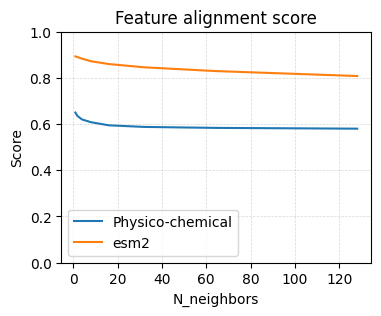

In [ ]:
n_neighbours = [1, 2, 4, 8, 16, 32, 64, 128]

fig, ax = plt.subplots(figsize=(4, 3))
for model_name in models.keys():
    xs = cache.model(model_name)(sequences)
    sm.utils.plot_feature_alignment_score(xs, labels, n_neighbours, label=model_name, ax=ax)

The sequences produced by ESM2 is better at seperating AMPs from non-AMPs than the physico-chemical embedding model.


#### Spearman correlation coefficient


The spearman correlation coefficient computes how well an embedding space aligns with a reference embedding space. We know AMPs are usually positively charged and amphiphilic, so lets see how well ESM2 align with these features.


In [ ]:
xs_esm2 = cache.model("esm2")(sequences)
xs_physico = cache.model("Physico-chemical")(sequences)

score = sm.utils.spearman_correlation_coefficient(xs_esm2, xs_physico)

print(f"Spearman correlation coefficient: {score:.2f}")

Spearman correlation coefficient: 0.27


### Visualization


Let's now visualize the embedding spaces.


First let's extract the sequences to visualize.


In [ ]:
n_samples = 300
seed = 42

datasets_to_plot = {
    name: sm.utils.random_subset(sequences, n_samples=n_samples, seed=seed) if len(sequences) > n_samples else sequences
    for name, sequences in datasets.items()
}

In [ ]:
embedders = {
    "esm2": sm.models.Esm2(
        model_name=sm.models.Esm2Checkpoint.t6_8M,
        batch_size=256,
        device="cpu",
        verbose=False,
    ),
}

In [ ]:
colors = ["red", "green"]

embedder_name = "esm2"
embedder = embedders[embedder_name]

In [ ]:
embeddings = {name: embedder(sequences) for name, sequences in datasets_to_plot.items()}

#### PCA


Let's do a PCA plot.


In [ ]:
xs_pca = sm.utils.pca(list(embeddings.values()))

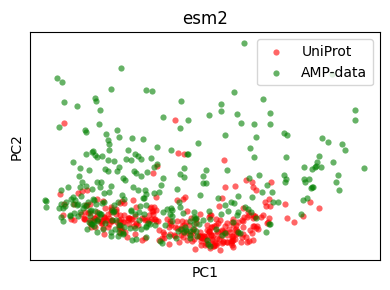

In [ ]:
sm.utils.plot_embeddings(
    xs_pca,
    labels=list(embeddings.keys()),
    colors=colors,
    title=embedder_name,
    xlabel="PC1",
    ylabel="PC2",
)

#### T-SNE


Let's do a T-SNE plot.


In [ ]:
xs_tsne = sm.utils.tsne(list(embeddings.values()))

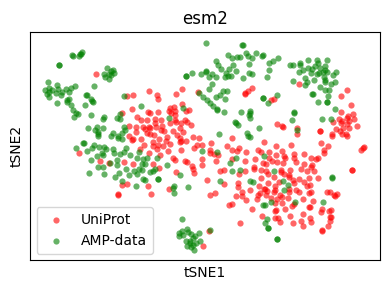

In [ ]:
sm.utils.plot_embeddings(
    xs_tsne,
    labels=list(embeddings.keys()),
    colors=colors,
    title=embedder_name,
    xlabel="tSNE1",
    ylabel="tSNE2",
)

#### UMAP


Let's do a UMAP plot.


In [ ]:
xs_umap = sm.utils.umap(list(embeddings.values()))

/Users/rasmus.larsen/work/hackathon-2025/seqme/.conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


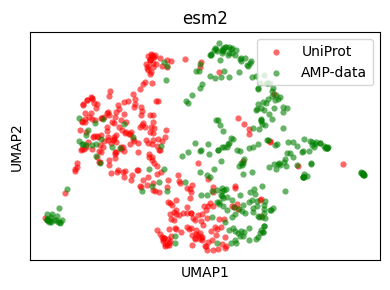

In [ ]:
sm.utils.plot_embeddings(
    xs_umap,
    labels=list(embeddings.keys()),
    colors=colors,
    title=embedder_name,
    xlabel="UMAP1",
    ylabel="UMAP2",
)

#### Embedding + Property


Let's do an UMAP for a single list of sequences and color those sequences based on a property.


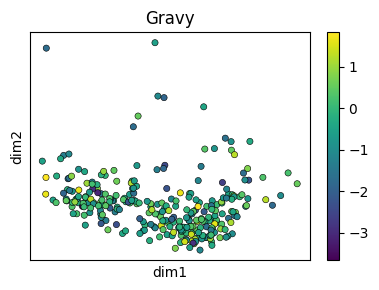

In [ ]:
name = "AMP-data"
property_model = sm.models.Gravy()

sm.utils.plot_embedding_with_value(
    xs_pca[0],
    values=property_model(datasets_to_plot[name]),
    title="Gravy",
    alpha=1.0,
)

## Property models


Let's start by loading some sequences.


In [ ]:
DATASET_PATH = "./data/amps.fasta"

In [ ]:
sequences = sm.utils.read_fasta_file(DATASET_PATH)

Let's create a histogram, kde and violin plot for a few properties.


In [ ]:
properties = {"Gravy": sm.models.Gravy(), "Molecular Weight": sm.models.MolecularWeight()}

In [ ]:
df = pd.DataFrame({name: prop(sequences) for name, prop in properties.items()})

### Histogram


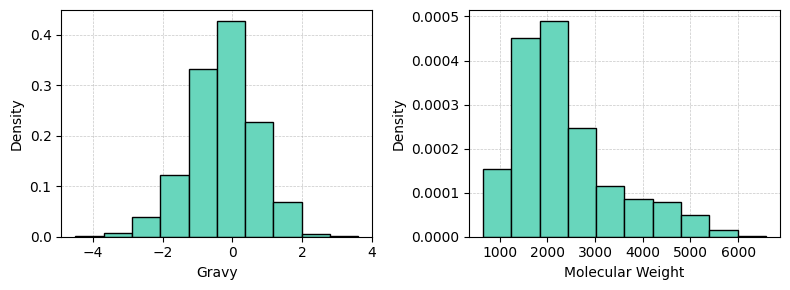

In [ ]:
per_ax_size = (4, 3)
n = len(properties)
fig, axes = plt.subplots(ncols=n, figsize=(per_ax_size[0] * n, per_ax_size[1]))

for i in range(len(axes)):
    col_name = df.columns[i]
    col = df[col_name]
    sm.utils.plot_hist(col.to_numpy(), xlabel=col_name, ax=axes[i])

fig.tight_layout()

### KDE


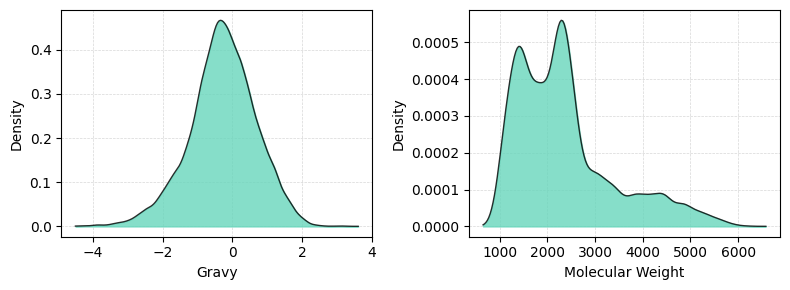

In [ ]:
per_ax_size = (4, 3)
n = len(properties)
fig, axes = plt.subplots(ncols=n, figsize=(per_ax_size[0] * n, per_ax_size[1]))

for i in range(len(axes)):
    col_name = df.columns[i]
    col = df[col_name]
    sm.utils.plot_kde(col.to_numpy(), xlabel=col_name, ax=axes[i])

fig.tight_layout()

### Violin


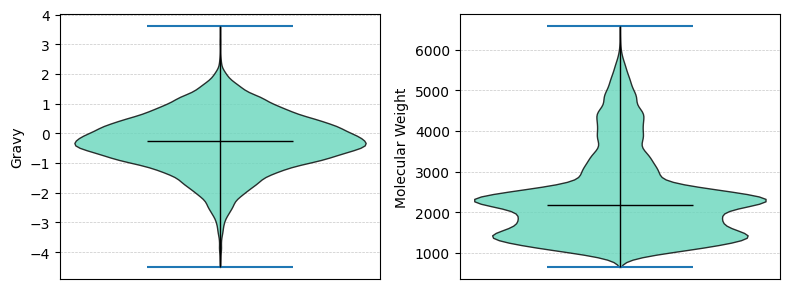

In [ ]:
per_ax_size = (4, 3)
n = len(properties)
fig, axes = plt.subplots(ncols=n, figsize=(per_ax_size[0] * n, per_ax_size[1]))

for i in range(len(axes)):
    col_name = df.columns[i]
    col = df[col_name]
    sm.utils.plot_violin(col.to_numpy(), xlabel=col_name, ax=axes[i])

fig.tight_layout()